In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import numpy as np
import os
import json
import random
from copy import deepcopy

import torch.utils.data as data
from torch.utils.data import sampler
from torchvision import datasets
import random

In [2]:
# 挂载网盘
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os
path='/content/gdrive/My Drive/Hongyi Li_ML/Code/hw14_life_long_learning'
os.chdir(path)
os.listdir(path)

['data',
 'data.ipynb',
 'ewc_acc.txt',
 'basic_acc.txt',
 'utils.ipynb',
 'train.ipynb',
 'mas_acc.txt',
 'scp_acc.txt',
 'model.ipynb',
 'model.ckpt',
 'model.opt',
 'main.ipynb']

In [4]:
%run utils.ipynb
%run data.ipynb
%run model.ipynb
%run train.ipynb

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class configurations(object):
  def __init__(self):
    self.batch_size=256
    self.num_epochs=10000
    self.store_epochs=250
    self.summary_epochs=250
    self.learning_rate=0.0005
    self.load_model=False
    self.store_model_path='./model'
    self.load_model_path='./model'
    self.data_path='./data'
    self.mode=None
    self.lifelong_coeff=0.5

In [ ]:
# Part1:对比MAS、EWC、Basic方法
if __name__=='__main__':
  mode_list=['mas','ewc','basic']
  coeff_list=[1,100,0]
  config=configurations()
  count=0
  for mode in mode_list:
    config.mode=mode
    config.lifelong_coeff=coeff_list[count]
    print('{} training'.format(config.mode))
    model,optimizer,tasks=build_model(config.data_path,config.batch_size,config.learning_rate)
    print('Finish build model')
    if config.load_model:
      model,optimizer=load_model(model,optimizer,config.load_model_path)
    task_loss,acc=train_process(model,optimizer,tasks,config)
    with open(f'./{config.mode}_acc.txt','w') as f:
      json.dump(acc,f)
    count+=1

mas training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.090  

Computing MAS
 train task MNIST [10000] loss:0.417  

Computing MAS
Computing MAS
 train task USPS [10000] loss:0.410  ewc training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.087  

 train task MNIST [10000] loss:0.051  

 train task USPS [10000] loss:0.008  basic training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.087  

 train task MNIST [10000] loss:0.013  

 train task USPS [10000] loss:0.000  

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_result(mode_list,task1,task2,task3):
  count=0
  for reg_name in mode_list:
    label=reg_name
    with open(f'./{reg_name}_acc.txt','r') as f:
      acc=json.load(f)
    if count==0:
      color='red'
    elif count==1:
      color='blue'
    elif count==2:
      color='purple'
    else:
      color='orange'
    ax1=plt.subplot(3,1,1)
    plt.plot(range(len(acc[task1])),acc[task1],color,label=label)
    ax1.set_ylabel(task1)
    ax2=plt.subplot(3,1,2,sharex=ax1,sharey=ax1)
    plt.plot(range(len(acc[task3]),len(acc[task1])),acc[task2],color,label=label)
    ax2.set_ylabel(task2)
    ax3=plt.subplot(3,1,3,sharex=ax1,sharey=ax1)
    ax3.set_ylabel(task3)
    plt.plot(range(len(acc[task2]),len(acc[task1])),acc[task3],color,label=label)
    count+=1
  plt.ylim((0.02,1.02))
  plt.legend()
  plt.show()
  return

mode_list=['ewc','mas','basic']
plot_result(mode_list,'SVHN','MNIST','USPS')

In [ ]:
# Part2:首先测试实作的SCP
# 测试scp程序
mode_list=['scp']
coeff_list=[1,100,0,10]
config=configurations()
count=3
for mode in mode_list:
  config.mode=mode
  config.lifelong_coeff=coeff_list[count]
  print('{} training'.format(config.mode))
  model,optimizer,tasks=build_model(config.data_path,config.batch_size,config.learning_rate)
  print('Finish build model')
  if config.load_model:
    model,optimizer=load_model(model,optimizer,config.load_model_path)
  task_loss,acc=train_process(model,optimizer,tasks,config)
  with open(f'./{config.mode}_acc.txt','w') as f:
    json.dump(acc,f)
  count+=1

In [8]:
# 对比MAS、EWC、Basic、SCP方法
if __name__=='__main__':
  mode_list=['mas','ewc','basic','scp']
  coeff_list=[1,100,0,1]
  config=configurations()
  count=0
  for mode in mode_list:
    config.mode=mode
    config.lifelong_coeff=coeff_list[count]
    print('{} training'.format(config.mode))
    model,optimizer,tasks=build_model(config.data_path,config.batch_size,config.learning_rate)
    print('Finish build model')
    if config.load_model:
      model,optimizer=load_model(model,optimizer,config.load_model_path)
    task_loss,acc=train_process(model,optimizer,tasks,config)
    with open(f'./{config.mode}_acc.txt','w') as f:
      json.dump(acc,f)
    count+=1

mas training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.079  

Computing MAS
 train task MNIST [10000] loss:0.458  

Computing MAS
Computing MAS
 train task USPS [10000] loss:0.444  ewc training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.090  

Computing EWC
 train task MNIST [10000] loss:0.065  

Computing EWC
 train task USPS [10000] loss:0.007  basic training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.078  

 train task MNIST [10000] loss:0.016  

 train task USPS [10000] loss:0.000  scp training
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Finish build model


 train task SVHN [10000] loss:0.090  

Computing SCP
 train task MNIST [10000] loss:0.273  

Computing SCP
Computing SCP
 train task USPS [10000] loss:0.573  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

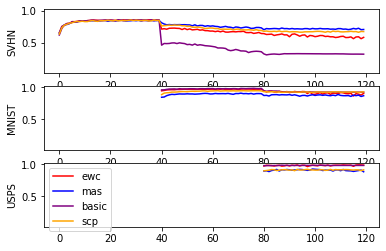

In [9]:
mode_list=['ewc','mas','basic','scp']
plot_result(mode_list,'SVHN','MNIST','USPS')